In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("/media/hdd/github/sprintdl/")

In [2]:
from sprintdl.main import *
import sprintdl

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

In [4]:
from sprintdl.models.xresnet import *

# Define required

In [5]:
fpath = Path("/media/hdd/Datasets/shotclassification/")
tfms = [make_rgb,to_byte_tensor,to_float_tensor, ResizeFixed(128)]
bs = 64

# Dataset stuff

# Converting json to csv
- only required path and label

In [6]:
import json

In [7]:
with open(fpath/"v1_full_trailer.json", "r") as f:
    label_json = json.load(f)

In [8]:
label_json['tt0444850']

{'0014': {'scale': {'label': 'CS', 'value': 1},
  'movement': {'label': 'Static', 'value': 4}},
 '0015': {'scale': {'label': 'CS', 'value': 1},
  'movement': {'label': 'Static', 'value': 4}},
 '0016': {'scale': {'label': 'ECS', 'value': 0},
  'movement': {'label': 'Static', 'value': 4}}}

In [9]:
key_lis = list(label_json.keys())

In [10]:
label_dic = {}
for key in key_lis:
    inner = label_json[key]
    in_keys = list(inner.keys())
    out_k = [(fpath/f"trailer/{key}/shot_{k}.mp4",inner[k]["scale"]["label"]) for k in in_keys]
    for x in out_k:
        label_dic[x[0]] =x[1]

In [11]:
key_df = pd.DataFrame(label_dic, index = [1]).T.reset_index()
key_df.columns = ["fpath","label"]
key_df.head(3)

,fpath,label
0,/media/hdd/Datasets/shotclassification/trailer...,CS
1,/media/hdd/Datasets/shotclassification/trailer...,CS
2,/media/hdd/Datasets/shotclassification/trailer...,ECS


In [12]:
key_df.label.unique()

array(['CS', 'ECS', 'MS', 'FS', 'LS'], dtype=object)

In [13]:
key_df.label.nunique()

5

In [14]:
key_df.to_csv(fpath/"labels.csv")

# Convert mp4 to images
- since all data is in images..

In [15]:
import cv2

In [16]:
def conv_to_frames(fname, fpath, label):

    vidcap = cv2.VideoCapture(str(fname))
#     print(fname)
    success,image = vidcap.read()
    count = 0
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
#         print(f"{fname.parent}/frame:{count}_{label}.jpg")
        cv2.imwrite(f"{fname.parent}/frame:{count}_{label}.jpg", image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1

In [17]:
list_to_run = [(x[1], x[2]) for x in key_df.itertuples()]

In [18]:
list_to_run[0]

(PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt0444850/shot_0014.mp4'),
 'CS')

In [19]:
def run_splitter(key_df, *args, **kwargs):
    fpath_name, label = key_df
    conv_to_frames(fpath/fpath_name,fpath, label)

In [20]:
# parallel(run_splitter, list_to_run,max_workers=8)

# Actual process

In [21]:
il = ImageList.from_files(fpath, tfms=tfms, max = 10000)

In [22]:
il

ImageList (10000 items)
[PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_ECS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:2_ECS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_CS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:0_MS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_MS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:2_MS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:0_FS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_FS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:0_CS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:2_CS.jpg')...]
Path: /media/hdd/Datasets/shotclassification

In [23]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))

In [24]:
sd

SplitData
Train: ImageList (7996 items)
[PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_ECS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:2_ECS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_CS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:0_MS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_MS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:2_MS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:0_FS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:2_FS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt3721936/frame:1_ECS.jpg'), PosixPath('/media/hdd/Datasets/shotclassification/trailer/tt3721936/frame:2_ECS.jpg')...]
Path: /media/hdd/Datasets/shotclassification
Valid: ImageList (2004 items)
[PosixPath('/medi

In [25]:
Path(Path('/media/hdd/Datasets/shotclassification/trailer/tt4511452/frame:1_ECS.jpg').name.split("_")[-1]).stem

'ECS'

In [26]:
ll = label_by_func(sd, lambda x:Path(Path(x).name.split("_")[-1]).stem , proc_y=CategoryProcessor())

In [27]:
n_classes = len(set(ll.train.y.items));n_classes

5

In [28]:
data = ll.to_databunch(bs, c_in=3, c_out=n_classes)

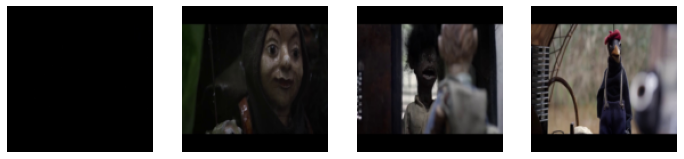

In [29]:
show_batch(data, 4)

# Training

In [30]:
lr = 1e-4
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
#     partial(ParamScheduler, 'mom', sched_mom),
    partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
    OverSampling,
    GradientClipping,
#     MixUp,
       partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [31]:
from sprintdl.models.efficientnet import *

In [32]:
# arch = partial(xresnet18, c_out =n_classes)()
# clear_memory()

In [33]:
arch = efficientnet(num_classes=n_classes, pretrained=True)

Loaded pretrained weights for efficientnet-b3


In [34]:
clear_memory()
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs+[PruningCallback], opt_func=opt_func)
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.435427,0.416083,1.064239,0.669162,00:49
1,0.929897,0.725488,0.887965,0.740519,00:50


Pruning: 130
Pruning: 130


In [35]:
learn.fit(20)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.937359,0.729990,0.970509,0.722056,00:50
1,1.098955,0.657329,1.233681,0.599800,00:52
2,1.198274,0.586043,1.329818,0.501497,00:51
3,1.213486,0.570035,1.442482,0.379741,00:52
4,1.240088,0.564032,1.607889,0.187126,00:50
5,1.279988,0.514507,1.659580,0.178643,00:52
6,1.400332,0.431841,1.645271,0.235529,00:52
7,1.535703,0.332666,1.610169,0.211078,00:53
8,1.603534,0.226488,1.605616,0.207086,00:52
9,1.612930,0.207479,1.602780,0.258483,00:52


Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130
Pruning: 130


KeyboardInterrupt: 